## Analyze trial results

In [1]:
import pandas as pd
import os, sys
import os.path
import numpy as np
import scipy
import scipy.stats
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import tabulate
%matplotlib inline

In [2]:
file_signature = 'populations.csv'

In [3]:
run_output_dir = !cd
run_output_dir = run_output_dir[0]
run_output_dir

'C:\\Users\\agutf\\repos\\apk-development\\analysis\\2018-09-13--06.02.24-1883294419__D3a_debug'

In [4]:
trial_end_date = int(365*3.5)-200 #the last normal recruit completes on day 958 

In [5]:
pops_file = [s for s in os.listdir(run_output_dir) if s.find(file_signature)>-1][0]

### Study details

In [6]:
header_output = pd.read_csv(os.path.join(run_output_dir, pops_file), nrows=1, header=1)
print(header_output[['vaccine_schedule', 'initial_pwid_count', 'vaccine_study_arm_n', 'vaccine_annual_loss', 'vaccine_dose2_day', 'vaccine_dose3_day', 'vaccine_enrollment_duration_days', 'vaccine_followup_purge_with_rna', 'vaccine_enrollment_launch_day', 'vaccine_enrollment_probability_positiveinnetwork', 'vaccine_enrollment_probability_unbiased', 'vaccine_followup1_periods', 'vaccine_followup2_periods', 'vaccine_followup_weeks']
])

  vaccine_schedule  initial_pwid_count  vaccine_study_arm_n  \
0              D3a               32000                  797   

   vaccine_annual_loss  vaccine_dose2_day  vaccine_dose3_day  \
0                  0.2               60.0              180.0   

   vaccine_enrollment_duration_days  vaccine_followup_purge_with_rna  \
0                               365                                0   

   vaccine_enrollment_launch_day  \
0                           30.0   

   vaccine_enrollment_probability_positiveinnetwork  \
0                                               1.0   

   vaccine_enrollment_probability_unbiased  vaccine_followup1_periods  \
0                                      0.0                         18   

   vaccine_followup2_periods  vaccine_followup_weeks  
0                          9                     4.0  


### Populations

In [7]:
pops_output = pd.read_csv(os.path.join(run_output_dir, pops_file), header=3)

In [8]:
pops_output.columns

Index(['BurnInMode', 'Tick', 'Year', 'incidence_daily', 'aggregate_courses',
       'quit_placebo_aggregate_vaccine', 'recr_study_aggregate_vaccine',
       'cmpl_study_chronic_aggregate_vaccine',
       'recr_placebo_aggregate_vaccine', 'started_study_aggregate_vaccine',
       ...
       'vaccinetrial_VaccineArm=noarm', 'populat_VaccineStage=notenrolled',
       'populat_VaccineStage=received_dose1',
       'populat_VaccineStage=received_dose2',
       'populat_VaccineStage=received_dose3', 'populat_VaccineStage=followup',
       'populat_VaccineStage=followup2', 'populat_VaccineStage=abandoned',
       'populat_VaccineStage=completed', 'Unnamed: 320'],
      dtype='object', length=321)

### Infection status

In [9]:
infections = pops_output[['Tick', 'BurnInMode', 'ABpreval_ALL', 'RNApreval_ALL']]

In [10]:
tmp = infections.Tick/365
infections["year"] = tmp

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


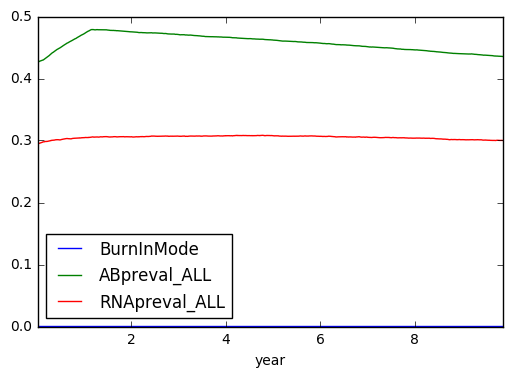

In [11]:
infections.plot(x="year", y=['BurnInMode', 'ABpreval_ALL', 'RNApreval_ALL'])

### Total population

In [12]:
simulated_population = pops_output[['Tick', 'population_ALL']]

In [13]:
tmp2 = simulated_population.Tick/365
simulated_population["year"] = tmp2

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [14]:
simulated_population.iloc[[0,1000,2000,-1]]

,Tick,population_ALL,year
0,9.001,32000.0,0.024660
1000,1009.001,32010.0,2.764386
2000,2009.001,32001.0,5.504112
3590,3599.001,32002.0,9.860277


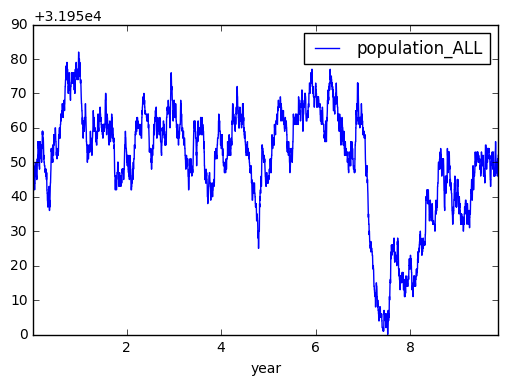

In [15]:
simulated_population.plot(x="year", y="population_ALL")

### Total recruited (i.e. started trials)

In [16]:
started_pops_fields = ['started_study_aggregate_vaccine', 'started_placebo_aggregate_vaccine']
started_pops=np.array(pops_output.loc[trial_end_date, started_pops_fields])
pops_output.loc[trial_end_date, ['Tick'] + started_pops_fields]

Tick                                 1086.001
started_study_aggregate_vaccine       800.000
started_placebo_aggregate_vaccine     799.000
Name: 1077, dtype: float64

### Total recruited (i.e. completed doses)

In [17]:
enrolled_pops_fields = ['recr_study_aggregate_vaccine', 'recr_placebo_aggregate_vaccine']
enrolled_pops=np.array(pops_output.loc[trial_end_date, enrolled_pops_fields])
pops_output.loc[trial_end_date, ['Tick'] + enrolled_pops_fields]

Tick                              1086.001
recr_study_aggregate_vaccine       727.000
recr_placebo_aggregate_vaccine     724.000
Name: 1077, dtype: float64

### Still in follow-up (should be small)

In [18]:
active_pops_fields = ['vaccinetrial_VaccineArm=study', 'vaccinetrial_VaccineArm=placebo']
active_pops=np.array(pops_output.loc[trial_end_date, active_pops_fields])
pops_output.loc[trial_end_date, ['Tick'] + active_pops_fields]

Tick                               1086.001
vaccinetrial_VaccineArm=study         6.000
vaccinetrial_VaccineArm=placebo      15.000
Name: 1077, dtype: float64

### Infection status

In [19]:
## note: cmpl_ variables are accumulators inside the simulation, and are valid even if individuals leave the simulation

#### chronic

In [20]:
chronic_pops=np.array(pops_output.loc[trial_end_date, ['cmpl_study_chronic_aggregate_vaccine', 'cmpl_placebo_chronic_aggregate_vaccine']])
pops_output.loc[trial_end_date, ['Tick', 'cmpl_study_chronic_aggregate_vaccine', 'cmpl_placebo_chronic_aggregate_vaccine']]

Tick                                      1086.001
cmpl_study_chronic_aggregate_vaccine        16.000
cmpl_placebo_chronic_aggregate_vaccine      39.000
Name: 1077, dtype: float64

#### not chronic

In [21]:
nonchronic_pops=np.array(pops_output.loc[trial_end_date, ['cmpl_study_notchronic_aggregate_vaccine', 'cmpl_placebo_notchronic_aggregate_vaccine']])
pops_output.loc[trial_end_date, ['Tick', 'cmpl_study_notchronic_aggregate_vaccine', 'cmpl_placebo_notchronic_aggregate_vaccine']]

Tick                                         1086.001
cmpl_study_notchronic_aggregate_vaccine       507.000
cmpl_placebo_notchronic_aggregate_vaccine     481.000
Name: 1077, dtype: float64

#### infected before completing doses (chronic or not)

In [22]:
incompl_inf_pops=np.array(pops_output.loc[trial_end_date, ['incompl_infected_study_aggregate_vaccine', 'incompl_infected_placebo_aggregate_vaccine']])
pops_output.loc[trial_end_date, ['Tick', 'incompl_infected_study_aggregate_vaccine', 'incompl_infected_placebo_aggregate_vaccine']]

Tick                                          1086.001
incompl_infected_study_aggregate_vaccine        19.000
incompl_infected_placebo_aggregate_vaccine      20.000
Name: 1077, dtype: float64

### Workload

In [23]:
#TODO = monthly work by category: recuitment, follow-up, follow-up2
pops_output['Month'] = pops_output['Tick'] / 30
pops_output['Month'] = round(pops_output['Month'] + 1)
#pops_output['Month']

In [24]:
#TODO: we need daily statistics in APK for totals by stage

### Recruitment and Drop out

In [25]:
recruited = pops_output[['Tick', 'started_study_aggregate_vaccine', 'started_study_aggregate_vaccine']]
recruited.columns = ['day', 'study_total', 'placebo_total']
recruited.set_index('day')
recruited = recruited.iloc[0:600]

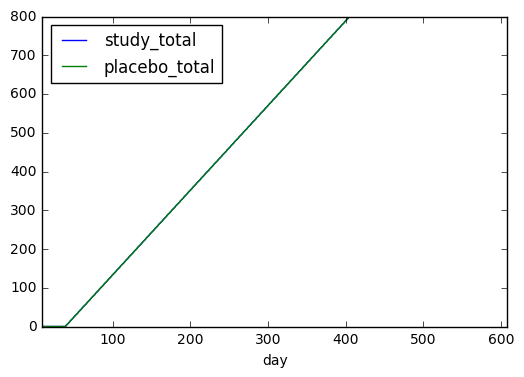

In [26]:
ax=recruited.plot(y='study_total', x='day')
recruited.plot(y='placebo_total', x='day', ax=ax)
plt.show()

In [27]:
dropouts = pops_output[['Tick', 'quit_study_aggregate_vaccine', 'quit_placebo_aggregate_vaccine']]
dropouts.columns = ['day', 'study_total_quit', 'placebo_total_quit']
dropouts.set_index('day');

In [28]:
d_study = dropouts.iloc[trial_end_date]['study_total_quit'] / pops_output.loc[trial_end_date]['started_study_aggregate_vaccine']
d_study

0.28749999999999998

In [29]:
d_placebo = dropouts.iloc[trial_end_date]['placebo_total_quit'] / pops_output.loc[trial_end_date]['started_placebo_aggregate_vaccine']
d_placebo

0.29536921151439299

In [30]:
dropouts = dropouts.iloc[0:600]

In [31]:
ddropouts = dropouts.diff()
ddropouts.drop(['day'], axis=1, inplace=True)
ddropouts.set_index(dropouts['day'])
ddropouts.columns = ['study', 'placebo']

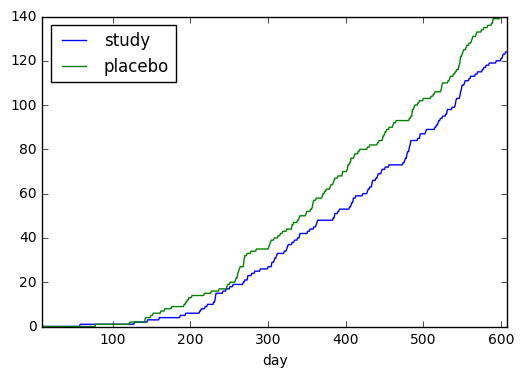

In [32]:
dropouts.columns = ['day', 'study', 'placebo']
ax=dropouts.plot(y='study', x='day', legend='study')
dropouts.plot(y='placebo', x='day', ax=ax, legend='placebo')
plt.show()

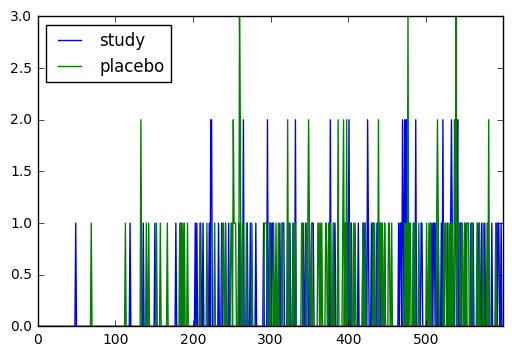

In [33]:
#fig = dropouts.plot('quit_study_aggregate_vaccine')
ax=ddropouts.plot(y='study')
ddropouts.plot(y='placebo', ax=ax)
plt.show()

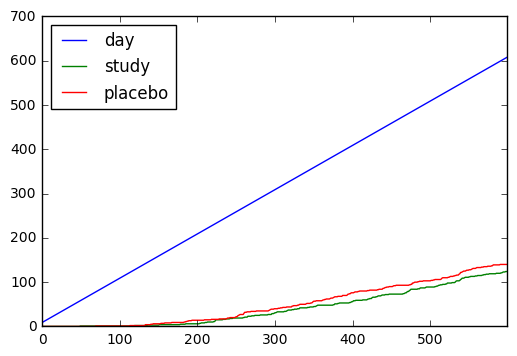

In [34]:
dropouts.plot()

### Total completed trial per protocol

In [35]:
total_completed = chronic_pops + nonchronic_pops
print('Study: %.0f, Placebo: %.0f'%(total_completed[0], total_completed[1]))

Study: 523, Placebo: 520


### Results

In [36]:
trial_contingency_table = np.reshape(np.concatenate((nonchronic_pops, chronic_pops), axis=0), newshape=(2,2))

In [37]:
print('Chi-square')
chi2, pvalchisq, dof, expected = scipy.stats.chi2_contingency(trial_contingency_table)

Chi-square


In [38]:
print('Fisher Exact')
fisher, pval = scipy.stats.fisher_exact(trial_contingency_table)
pval

Fisher Exact


0.0013485834331594183

## Vaccine efficacy:
$$ VE_𝑎 = 1 − 𝑎_{vaccine}/𝑎_{placebo} $$

In our case, we are interested in the prevention of chronic infection.  Therefore, we calculate:
$a_{vaccine} = $(HCV chronic vaccinees) / (total vaccinees)

and similarly for the placebo group

In [39]:
a_study = (chronic_pops[0] / total_completed[0])
a_study

0.030592734225621414

In [40]:
a_placebo = (chronic_pops[1] / total_completed[1])
a_placebo

0.074999999999999997

In [41]:
VE = 1 - (a_study/a_placebo)

## Summary of results

In [49]:
table = [["Results on day %d"%(trial_end_date,),"Study","Placebo"],
         ['Recruited'] + ['%d'%(x,) for x in started_pops],
         ['Received all doses'] + ['%d'%(x,) for x in enrolled_pops],
         ['Infected before final']  + ['%d'%(x,) for x in incompl_inf_pops],
         ['Dropout rate']  + ['%.0f%%'%(d_study*100), '%.0f%%'%(d_placebo*100)],
         ['Still in follow-up at day %d'%(trial_end_date)] + ['%d'%(x,) for x in active_pops], 
         ["    Chronic"] + ['%d'%(x,) for x in chronic_pops],
         ["    Not chronic"] + ['%d'%(x,) for x in nonchronic_pops],
         ["Attack rate"] + ['%.1f%%'%(a_study*100), '%.1f%%'%(a_placebo*100)],
         ["VE"] + ["%.2f%%"%(100*VE), ""]
        ]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

Results on day 1077,Study,Placebo
Recruited,800,799
Received all doses,727,724
Infected before final,19,20
Dropout rate,29%,30%
Still in follow-up at day 1077,6,15
Chronic,16,39
Not chronic,507,481
Attack rate,3.1%,7.5%
VE,59.21%,


In [57]:
print('Fisher\'s exact test gives p=%.6f, which is %s.  The estimated vaccine efficacy is %.1f%%'%(pval, 'statistically significant' if pval<0.05 else 'not statistically significant', 100*VE,))

Fisher's exact test gives p=0.001349, which is statistically significant.  The estimated vaccine efficacy is 59.2%
